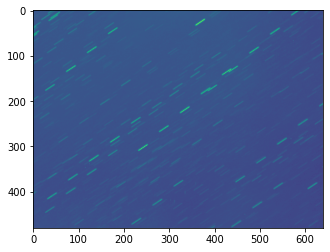

In [1]:
%matplotlib inline

import numpy as np
from skimage.color import rgb2gray
from skimage.feature import *
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform, SimilarityTransform
import matplotlib.pyplot as plt
from skimage import util
from skimage import io
from skimage import exposure
from skimage import morphology
from skimage import measure
from skimage import filters
import json

def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict

seqid = 1121
frames = [util.img_as_float(io.imread(f"../spotGEO/train/{seqid}/{i}.png", as_gray=True)) for i in range(1, 6)]
frames = np.array(frames)

plt.imshow(np.max(frames, axis=0), vmin=0, vmax=1)
plt.show()

Detected  1 objects


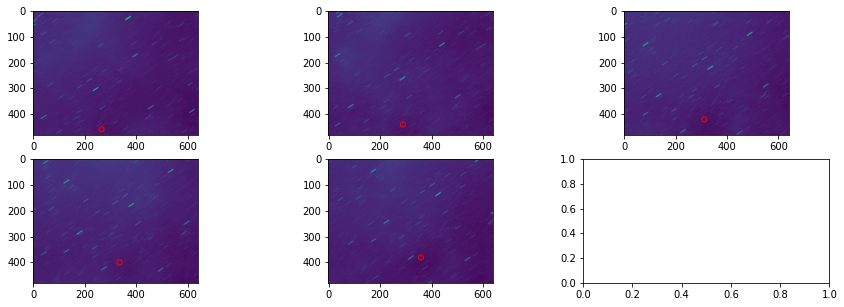

In [2]:
# Get objects coords for seqid

dataset = read_annotation_file('../spotGEO/train_anno.json')

def get_objects(seqid):
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0,1)

def draw_circle(ax, x, y, r):
    circle = plt.Circle((x, y), r, color='r', fill=False)
    ax.add_artist(circle)
    
def draw_target(ax, x, y):
    circle = plt.Circle((x, y), 10, color='r', fill=False)
    ax.add_artist(circle)
    
def draw_prediction(ax, x, y):
    circle = plt.Circle((x, y), 10, color='g', fill=False)
    ax.add_artist(circle)

targets = get_objects(seqid)

print("Detected ", len(targets), "objects")

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for frameid in range(0,5):
    axs[frameid].imshow(frames[frameid])    
    for target in targets[:,frameid]:
        draw_target(axs[frameid], target[0], target[1])    
plt.show()

In [3]:
from skimage import registration
from skimage import transform

def register(src, dst):
    shifts, _, _ = registration.phase_cross_correlation(dst, src, upsample_factor=100)
    return SimilarityTransform(translation=-np.flip(shifts))

In [4]:
T1 = register(frames[1], frames[0])
T2 = register(frames[2], frames[1])
T3 = register(frames[3], frames[2])
T4 = register(frames[4], frames[3])

In [5]:
# Sometimes the transformation matrix may return outlier transformations
# here we assume the same transformation matrix repeated for all the frames
Q = np.array([T.params.ravel() for T in [T1, T2, T3, T4]])

T = np.median(Q, axis=0).reshape(3,3)

print(T)

[[  1.      0.     45.6  ]
 [  0.      1.    -41.275]
 [  0.      0.      1.   ]]


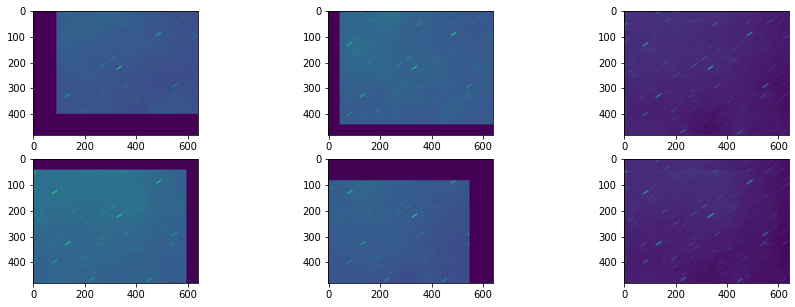

In [6]:
# Transform to frame 2 coords

frame0_2 = transform.warp(frames[0], np.linalg.inv(T) @ np.linalg.inv(T))
frame1_2 = transform.warp(frames[1], np.linalg.inv(T))
frame2_2 = frames[2]
frame3_2 = transform.warp(frames[3], T)
frame4_2 = transform.warp(frames[4], T @ T)

sequence = np.array([frame0_2, frame1_2, frame2_2, frame3_2, frame4_2])

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for i, frame in enumerate(sequence):
    axs[i].imshow(frame)
    
axs[i+1].imshow(np.max(sequence, axis=0))

plt.show()

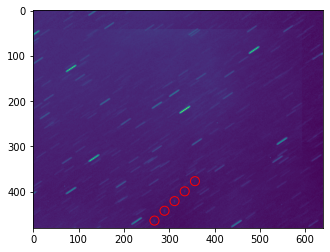

In [7]:
# Transform to frame 2 coords

Ts = [
    T @ T,
    T,
    np.eye(3),
    np.linalg.inv(T),
    np.linalg.inv(T @ T)
]

plt.imshow( np.max(sequence, axis=0) )

for frameid in range(0,5):
    if len(targets) == 0:
        break
    Z = transform.matrix_transform(targets[:,frameid], Ts[frameid])
    for z in Z:        
        draw_target(plt.gcf().gca(), z[0], z[1])
plt.show()

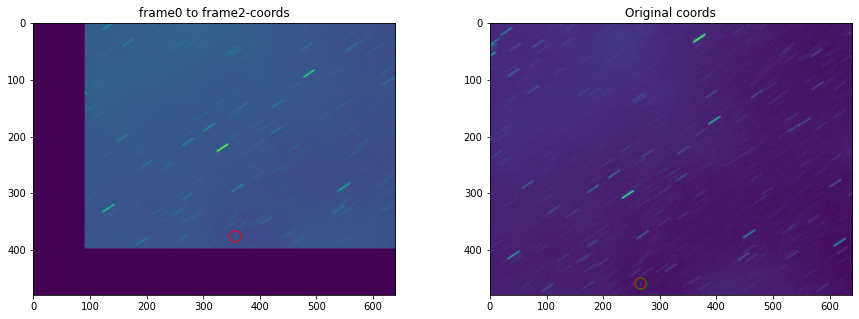

In [8]:
%matplotlib inline

frameid = 0

if len(targets) > 0:
    Z = transform.matrix_transform(targets[:,frameid], Ts[frameid])
else:
    Z = np.array([])

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs = axs.ravel()

axs[0].imshow(sequence[frameid])
axs[0].set_title(f'frame{frameid} to frame2-coords')
for z in Z:
    draw_target(axs[0], z[0], z[1])
    
axs[1].imshow(frames[frameid])
axs[1].set_title('Original coords')
for target in targets[:,frameid]:
    draw_target(axs[1], target[0], target[1])

noise = np.random.normal(size=Z.shape, scale=2.0)

if len(Z) > 0:
    Zo = transform.matrix_transform(Z + noise, np.linalg.inv(Ts[frameid]))
else:
    Zo = np.array([])

for zo in Zo:
    draw_prediction(axs[1], zo[0], zo[1])

plt.show()

Proposal 42


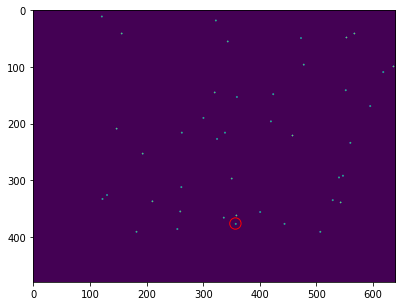

Proposal 15


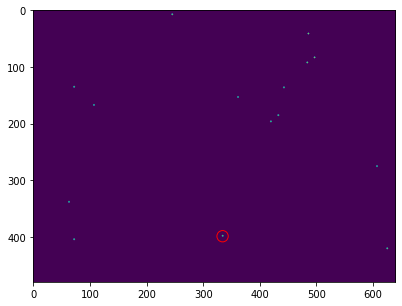

Proposal 80


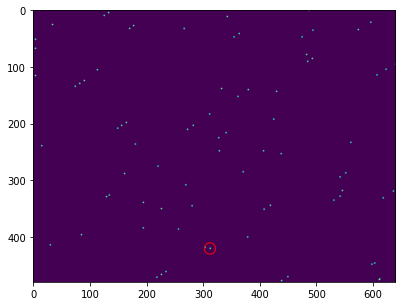

Proposal 15


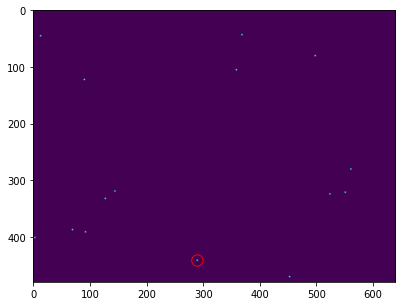

Proposal 29


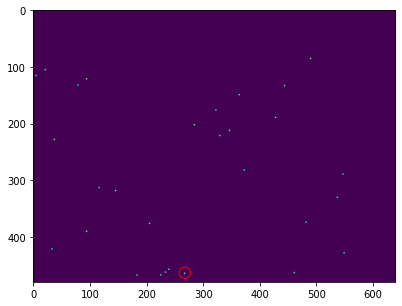

In [9]:
%matplotlib inline

maxima = []
Iproposal = np.zeros_like(frames[0])

for frameid in range(0,5):
    if len(targets) > 0:
        Z = transform.matrix_transform(targets[:,frameid], Ts[frameid])
    else:
        Z = np.array([])

    # Use as Ibase the max of all but frameid frames
    Ibase = np.max(sequence[np.arange(len(sequence)) != frameid], axis=0)

    Idiff = (sequence[frameid] - Ibase)*(sequence[frameid]>0)

    Imaxima = morphology.h_maxima(Idiff, 0.02, selem=morphology.diamond(5))

    print( 'Proposal', len(np.where(Imaxima)[0]) )

    maxima.append(Imaxima)
    Iproposal += Imaxima
    
    Iout = morphology.dilation(Imaxima)    
    
    plt.figure(figsize=(10,5))
    plt.imshow(Iout, vmin=0, vmax=1)
    for z in Z:
        draw_target(plt.gcf().gca(), z[0], z[1])
    plt.show()

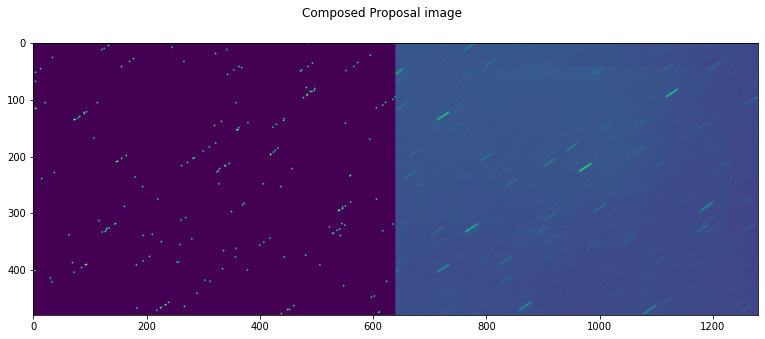

In [10]:
%matplotlib inline

Iseq = np.max(sequence, axis=0)

plt.figure(figsize=(15,5))
plt.suptitle('Composed Proposal image')
plt.imshow(np.hstack([morphology.dilation(Iproposal), Iseq]), vmin=0, vmax=1)
plt.show()

(1600, 360)
Detected  10 lines


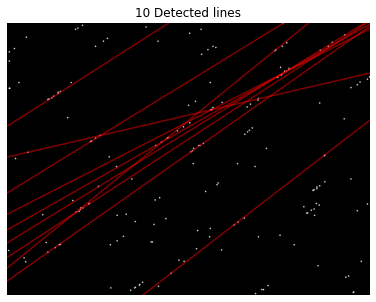

In [11]:
# For each cluster we can check the presence of "interesting lines"
%matplotlib inline

from skimage.transform import hough_line, hough_line_peaks

x1, x2 = np.where(Iproposal > 0)
X = np.c_[x1, x2]

Iin = np.zeros(Iproposal.shape, dtype='bool')
Iin[X[:,0].astype('int'), np.int32(X[:,1])] = True

tested_angles = np.linspace(-np.pi/2, np.pi/2, 360)
h, theta, d = hough_line(Iin, theta=tested_angles)

h1 = h*(h > 3)*(h < 6)

print(h1.shape)

n = 0

image = Iin.copy()

plt.figure(figsize=(15,5))

origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h1, theta, d, num_peaks=10)):
    n += 1
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r', alpha=0.5)
plt.imshow(morphology.binary_dilation(image), cmap='gray')
plt.xlim(origin)
plt.ylim((image.shape[0], 0))
plt.axis('off')
plt.title(f'{n} Detected lines')
    
print('Detected ', n, 'lines')

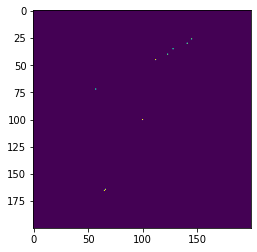

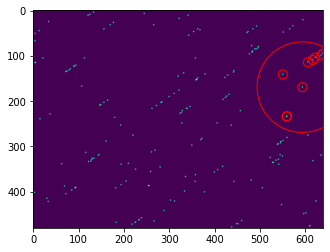

In [12]:
from sklearn import metrics

d = metrics.pairwise_distances(X)

def view_centered(X, r, p):
    '''Returns image centered at p with given radius r'''
    Iout = np.zeros((2*r, 2*r))
    offset = (X[d[p] < r] - X[p]) + [r, r]
    Iout[offset[:, 0], offset[:,1]] = 1
    
    return Iout


Iout = view_centered(X, 100, 65)

plt.imshow(Iout)
plt.show()

# Behind the scene
plt.imshow(morphology.binary_dilation(Iproposal))

draw_circle(plt.gcf().gca(), X[65, 1], X[65, 0], 100)
draw_circle(plt.gcf().gca(), X[34, 1], X[34, 0], 10)
draw_circle(plt.gcf().gca(), X[36, 1], X[36, 0], 10)
draw_circle(plt.gcf().gca(), X[37, 1], X[37, 0], 10)
draw_circle(plt.gcf().gca(), X[41, 1], X[41, 0], 10)
draw_circle(plt.gcf().gca(), X[42, 1], X[42, 0], 10)
draw_circle(plt.gcf().gca(), X[56, 1], X[56, 0], 10)
draw_circle(plt.gcf().gca(), X[65, 1], X[65, 0], 10)
draw_circle(plt.gcf().gca(), X[89, 1], X[89, 0], 10)
draw_circle(plt.gcf().gca(), X[90, 1], X[90, 0], 10)

plt.show()

(480, 640)


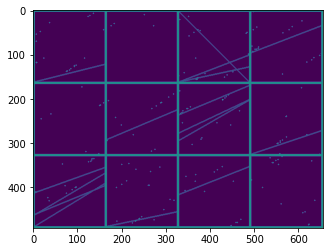

In [13]:
from skimage import util
from skimage import draw

print(Iproposal.shape)

r = np.gcd(Iproposal.shape[0], Iproposal.shape[1])

# Iproposal_pad = np.pad(Iproposal, [(10, 10), (30,30)])
Iproposal_pad = Iproposal.copy()

blocks = util.view_as_blocks(Iproposal_pad, (r,r))
h_blocks, w_blocks = blocks.shape[:2]
blocks = blocks.reshape(-1,r,r)


def detect_lines(Iin):
    tested_angles = np.linspace(-np.pi/2, np.pi/2, 360)
    h, theta, d = hough_line(Iin, theta=tested_angles)

    h1 = h*(h > 3)*(h < 6)

    n = 0
    for _, angle, dist in zip(*hough_line_peaks(h1, theta, d, num_peaks=1)):
        n += 1
    
    return n

def detect_and_draw_lines(Iin):
    tested_angles = np.linspace(-np.pi/2, np.pi/2, 360)
    h, theta, d = hough_line(Iin, theta=tested_angles)

    h1 = h*(h > 3)*(h < 6)

    Iout = Iin.copy()
    
    m = Iout.shape[0]-1
    
    for _, angle, dist in zip(*hough_line_peaks(h1, theta, d, num_peaks=10)):
        y0, y1 = (dist - np.array([0, 99]) * np.cos(angle)) / np.sin(angle)
        
        y0 = np.clip(y0, 0, m)
        y1 = np.clip(y1, 0, m)
        
        Iout[draw.line(int(y0), 0, int(y1), m)] = 0.5
        
    return Iout


Iblocks = [detect_and_draw_lines(block) for block in blocks]

Iout = util.montage(Iblocks, grid_shape=(h_blocks, w_blocks), fill=1.0, padding_width=3)

plt.imshow(morphology.dilation(Iout))
plt.show()

In [14]:
# Filter isolated pixels -> we consider only at least groups of 3 pixels
# It does not really improve, but better than nothing...

r = 100
d = metrics.pairwise_distances(X)

S = np.sum(d < r, axis=-1)
Xsel = X[S > 2]

print(X.shape)
print(Xsel.shape)

(180, 2)
(179, 2)


22 0.905519496651216


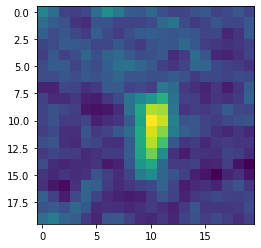

In [16]:
frameid = 1

Imaxima = maxima[frameid]

x1, x2 = np.where(Imaxima)
X = np.int32(np.c_[x1, x2])

Iin = sequence[frameid]


def feature_of_region_area(Iregion):
    if Iregion.shape[0] == 0 or Iregion.shape[1] == 0:
        return 0
    thr = filters.threshold_otsu(Iregion)
    regions = morphology.label(Iregion > thr)
    regions = measure.regionprops(regions)
    if len(regions) > 0:
        return np.max([region.area for region in regions])
    else:
        return 0

    
def feature_of_region_eccentricity(Iregion):
    if Iregion.shape[0] == 0 or Iregion.shape[1] == 0:
        return 0
    thr = filters.threshold_otsu(Iregion)
    regions = morphology.label(Iregion > thr)
    regions = measure.regionprops(regions)
    if len(regions) > 0:
        return np.max([region.eccentricity for region in regions])
    else:
        return 1
    
areas = [feature_of_region_area(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]
eccentr = [feature_of_region_eccentricity(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]

idxs = [idx for idx, (area, ecc) in enumerate(zip(areas, eccentr)) if (area > 10) and (area < 35) and ecc < 0.95]

for idx in idxs:
    r0, c0 = X[idx]
    Iregion = Iin[r0-10:r0+10, c0-10:c0+10]
    
    print(areas[idx], eccentr[idx])
    
    plt.imshow(Iregion)
    plt.show()
    

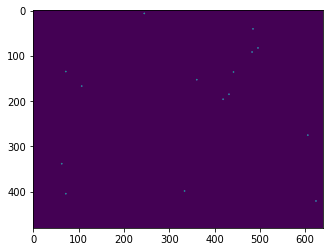

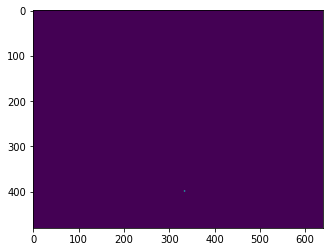

In [17]:
Xsel = X[idxs]

plt.imshow(morphology.dilation(Imaxima))
plt.show()

Imaxima_sel = np.zeros_like(Imaxima)
Imaxima_sel[Xsel[:,0], Xsel[:,1]] = 1

plt.imshow(morphology.dilation(Imaxima_sel))
plt.show()

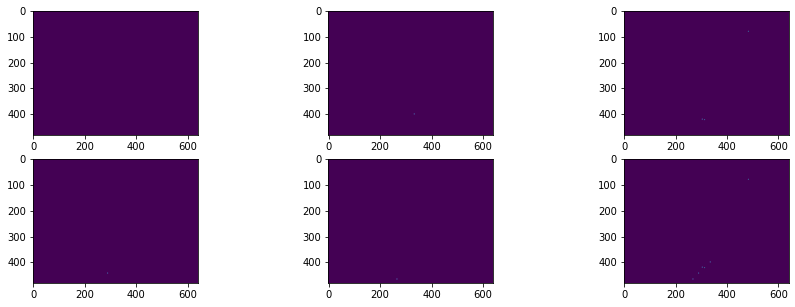

In [18]:
def extract_proposal(frameid):
    Imaxima = maxima[frameid]

    x1, x2 = np.where(Imaxima)
    X = np.int32(np.c_[x1, x2])

    Iin = sequence[frameid]

    areas = [feature_of_region_area(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]
    eccentr = [feature_of_region_eccentricity(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]

    idxs = [idx for idx, (area, ecc) in enumerate(zip(areas, eccentr)) if (area > 10) and (area < 35) and ecc < 0.95]

    Xsel = X[idxs]
    
    Imaxima_sel = np.zeros_like(Imaxima)
    Imaxima_sel[Xsel[:,0], Xsel[:,1]] = 1
    
    return Imaxima_sel

Iout = np.array([extract_proposal(i) for i in range(0, 5)])

fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()

for i, I in enumerate(Iout):
    axs[i].imshow(morphology.dilation((I)))
Iproposal = np.max(Iout, axis=0)
axs[i+1].imshow(morphology.dilation(Iproposal))
plt.show()

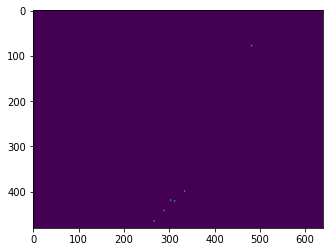

In [19]:
plt.imshow( morphology.dilation(Iproposal) )
plt.show()

In [145]:
# Append frameid to proposal coords

def extract_proposal(Iin, X, frameid):
    areas = [feature_of_region_area(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]
    eccentr = [feature_of_region_eccentricity(Iin[r0-10:r0+10, c0-10:c0+10]) for r0, c0 in X]
    idxs = [idx for idx, (area, ecc) in enumerate(zip(areas, eccentr)) if (area > 10) and (area < 35) and ecc < 0.95]
    labels = np.zeros(len(X))
    labels[idxs] = 1    
    return labels


X = np.array([ np.c_[np.where(Imax)] for Imax in maxima])
frameidxs = [np.repeat(i, len(x)) for i, x in enumerate(X)]
labels = [extract_proposal(sequence[i], x, i) for i, x in enumerate(X)]

X = np.c_[np.concatenate(frameidxs), np.concatenate(X), np.concatenate(labels)]

Xsel = X[X[:,-1]>0,:-1]

print(Xsel)

[[  1. 398. 334.]
 [  2.  78. 482.]
 [  2. 418. 303.]
 [  2. 420. 312.]
 [  3. 441. 289.]
 [  4. 464. 267.]]


In [155]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler

X_tr = StandardScaler().fit_transform(Xsel[:,[1,2]])

_, labels = cluster.dbscan(X_tr, min_samples=3)
labels += 1 # number of objects is offset by 1

objs = np.c_[Xsel, labels][labels > 0]

print(objs)

[[  1. 398. 334.   1.]
 [  2. 418. 303.   1.]
 [  2. 420. 312.   1.]
 [  3. 441. 289.   1.]
 [  4. 464. 267.   1.]]


Found  1 objects
[[  1. 398. 334.]
 [  2. 418. 303.]
 [  2. 420. 312.]
 [  3. 441. 289.]
 [  4. 464. 267.]]


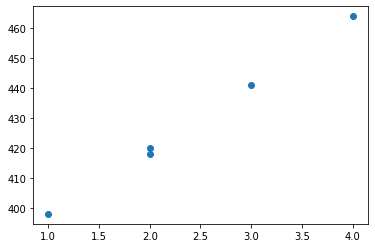

In [163]:
nobjects = int(objs[:,-1].max())
print('Found ', nobjects, 'objects')

for n in range(nobjects):
    # coords = objs[(objs[:,-1] == (n+1))][:,[1,2]]
    coords = objs[(objs[:,-1] == (n+1)), :-1]
    print(coords)
    
    plt.scatter(coords[:,0], coords[:,1])
plt.show()

[[  1. 398. 334.]
 [  2. 418. 303.]
 [  2. 420. 312.]
 [  3. 441. 289.]
 [  4. 464. 267.]]
6.161538461538464 7.123076923076909 19.119875130072895 10527.209762861414


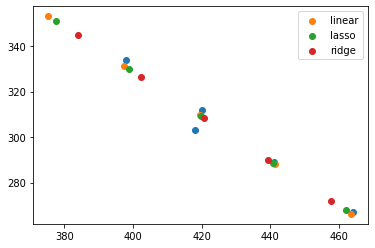

In [243]:
# Interpolate
from sklearn.linear_model import LinearRegression

coords = objs[:, :-1]

print(coords)

lr_x = LinearRegression().fit(coords[:,0].reshape(-1,1), coords[:,1])
lr_y = LinearRegression().fit(coords[:,0].reshape(-1,1), coords[:,2])

t = np.arange(0, 5).reshape(-1, 1)

x_pred = lr_x.predict(t)
y_pred = lr_y.predict(t)

# x_pred = np.random.uniform(370, 460, size=x_pred.shape)
# y_pred = np.random.uniform(370, 460, size=y_pred.shape)

from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics

lr = LinearRegression().fit(coords[:,0].reshape(-1, 1), coords[:, [1, 2]])
lasso = Lasso().fit(coords[:,0].reshape(-1, 1), coords[:, [1, 2]])
ridge = Ridge().fit(coords[:,0].reshape(-1, 1), coords[:, [1, 2]])

v_pred = lr.predict(t)
lasso_pred = lasso.predict(t)
ridge_pred = ridge.predict(t)

# metrics.mean_squared_error

lr_score = metrics.mean_squared_error(coords[:,[1,2]], lr.predict(coords[:,0].reshape(-1, 1)))
lasso_score = metrics.mean_squared_error(coords[:,[1,2]], lasso.predict(coords[:,0].reshape(-1, 1)))
ridge_score = metrics.mean_squared_error(coords[:,[1,2]], ridge.predict(coords[:,0].reshape(-1, 1)))

score = metrics.mean_squared_error(coords[:,[1,2]], np.random.uniform(270, 350, size=coords[:,[1,2]].shape))

print(lr_score, lasso_score, ridge_score, score)

plt.scatter(coords[:,1], coords[:,2])
plt.scatter(v_pred[:,0], v_pred[:,1], label='linear')
plt.scatter(lasso_pred[:,0], lasso_pred[:,1], label='lasso')
plt.scatter(ridge_pred[:,0], ridge_pred[:,1], label='ridge')

plt.legend()
plt.show()

In [290]:
c_coords = []

for i in range(0, 5):
    c_frame = coords[(coords[:,0]).astype('int') == i]
    if len(c_frame) == 0:
        v = lr.predict([[i]])[0]
        c_coords.append(v)
    elif len(c_frame) > 1:
        v0 = lr.predict([[i]])[0]
        d = c_frame[:,[1, 2]] - v0
        idx = np.argmin(d)
        v = c_frame[idx,[1,2]]
        c_coords.append(v)
    else:
        c_coords.append(c_frame[0,[1,2]])
    
c_coords = np.array(c_coords)

print(c_coords)
print(v_pred)

[[375.30769231 353.15384615]
 [398.         334.        ]
 [420.         312.        ]
 [441.         289.        ]
 [464.         267.        ]]
[[375.30769231 353.15384615]
 [397.34615385 331.42307692]
 [419.38461538 309.69230769]
 [441.42307692 287.96153846]
 [463.46153846 266.23076923]]


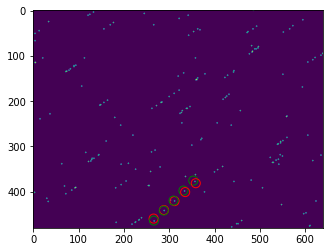

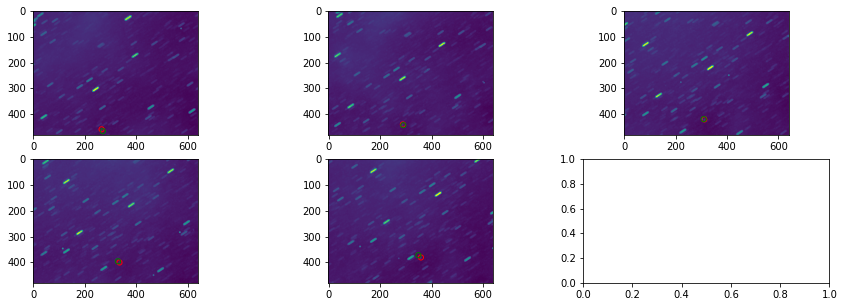

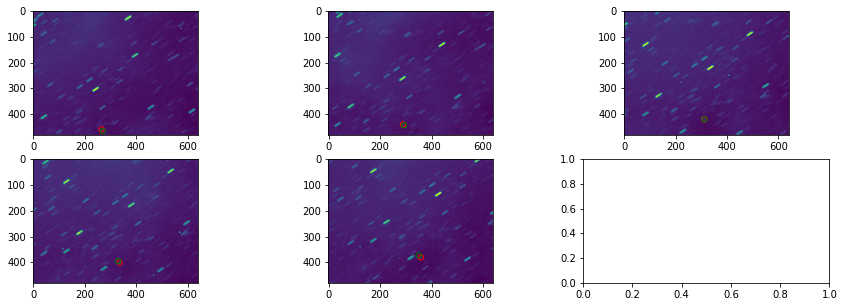

In [288]:
axs = plt.gcf().gca()

plt.imshow(morphology.dilation(np.max(maxima, axis=0)))

for frameid in range(0,5):    
    vi_pred = v_pred[frameid]
    x_pred, y_pred = vi_pred[1], vi_pred[0]
    
    for target in targets[:,frameid]:
        draw_target(axs, target[0], target[1])
        draw_prediction(axs, x_pred, y_pred)
plt.show()


fig, axs = plt.subplots(2, 3, figsize=(15, 5))
axs = axs.ravel()

for frameid in range(0,5):
    vi_pred = transform.matrix_transform(v_pred[frameid], Ts[frameid])
    x_pred, y_pred = vi_pred[0,1], vi_pred[0,0]
    
    axs[frameid].imshow(morphology.dilation(frames[frameid], selem=morphology.square(5)))
    
    for target in targets[:,frameid]:
        draw_target(axs[frameid], target[0], target[1])
        draw_prediction(axs[frameid], x_pred, y_pred)
plt.show()

# Interpoleted coords

fig, axs = plt.subplots(2, 3, figsize=(15, 5))
axs = axs.ravel()

for frameid in range(0,5):
    vi_pred = transform.matrix_transform(c_coords[frameid], Ts[frameid])
    x_pred, y_pred = vi_pred[0,1], vi_pred[0,0]
    
    axs[frameid].imshow(morphology.dilation(frames[frameid], selem=morphology.square(5)))
    
    for target in targets[:,frameid]:
        draw_target(axs[frameid], target[0], target[1])
        draw_prediction(axs[frameid], x_pred, y_pred)
plt.show()

In [ ]:
# Maybe similar result if we use frames directly without transformation?

for frameid in range(0,5):
    Ibase1 = np.mean(frames[np.arange(len(frames)) != frameid], axis=0)
    
    Idiff = (frames[frameid] - Ibase1)
    Imaxima = morphology.h_maxima(Idiff, 0.02, selem=morphology.diamond(5))
    
    Iout = morphology.dilation(Imaxima)
    
    print( 'Proposal', len(np.where(Imaxima)[0]) )
    
    plt.figure(figsize=(10,5))
    plt.imshow(Iout, vmin=0, vmax=1)
    
    for target in targets[:,frameid]:
        draw_target(plt.gcf().gca(), target[0], target[1])
        
    plt.show()